In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
#print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Sep  5 23:17:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 30%   36C    P0    N/A /  75W |    767MiB /  4039MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [154]:
class PersonDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        
        # здесь преобразуем картинки для обучения
        if self.mode == 'train':
            transform = transforms.RandomApply(nn.ModuleList([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                # transforms.RandomGrayscale(p=0.1),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
                # transforms.RandomAutocontrast(),
                # transforms.RandomVerticalFlip(p=0.3)
            ]), p=0.5)
            
        # здесь нормализуем и переводим в тензор
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
          x = transform(x)

        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = normalize(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [155]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [156]:
TRAIN_DIR = Path('images')
TEST_DIR = Path('test_im')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.png')))
# test_files = sorted(list(TEST_DIR.rglob('*.png')))

In [157]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.30, \
                                          stratify=train_val_labels)

In [158]:
# были некоторые проблемы с гугл диском? поэтому проверял все ли файлы подгрузились
# здесь количество больше за счет ручного копирования малочисленных классов
len(train_val_files)

1765

In [159]:
# проверял количество классов
len(np.unique(train_val_labels))

11

In [160]:
val_dataset = PersonDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

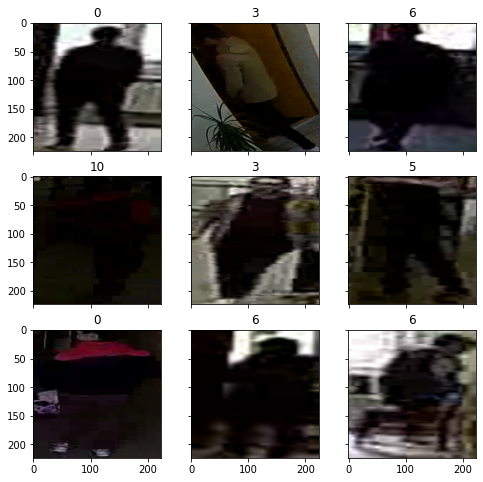

In [161]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [162]:
from torchvision import models
my_model = models.resnet18(pretrained=True)
#my_model2 = models.alexnet(pretrained=True)

In [163]:
#замораживаю параметры, оставляю для обучения только крайние слои
for i, child in enumerate(my_model.children()):
    for param in child.parameters():
        param.requires_grad = False
        if i == 9 or i == 7 or i == 6:
            param.requires_grad = True

#последний полносвязный заменен на линейные выходные слои из алекснет (не все, экспериментировал)
my_model.fc = nn.Sequential(
    #nn.Dropout(p=0.5, inplace=False),
    #nn.Linear(in_features=512, out_features=512, bias=True),
    #nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=512, out_features=11, bias=True))

my_model = my_model.to(DEVICE)
#my_model2 = my_model2.to(DEVICE)

In [164]:
# проверял как заморозились параметры сети
for i, child in enumerate(my_model.children()):
    for param in child.parameters():
        print(i, param.requires_grad)

0 False
1 False
1 False
4 False
4 False
4 False
4 False
4 False
4 False
4 False
4 False
4 False
4 False
4 False
4 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
5 False
6 True
6 True
6 True
6 True
6 True
6 True
6 True
6 True
6 True
6 True
6 True
6 True
6 True
6 True
6 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
7 True
9 True
9 True
9 True
9 True


In [165]:
# проверяю как изменилась сеть
my_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [166]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [167]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [168]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #добавил в оптимизатор параметр lr = 0.0001
        opt = torch.optim.Adam(model.parameters(), lr = 0.00001, )
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [169]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [170]:
n_classes = len(np.unique(train_val_labels))

# использовал переменную simple_cnn чтоб дальше не править код (для удобства)
simple_cnn = my_model.to(DEVICE) #SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
#print(simple_cnn)

we will classify :11


Запустим обучение сети.

In [171]:
if val_dataset is None:
    val_dataset = PersonDataset(val_files, mode='val')
    
train_dataset = PersonDataset(train_files, mode='train')

In [172]:
#здесь история дообучения 5 эпох после 15. Первые 15 эпох остались на графике ниже
history = train(train_dataset, val_dataset, model=my_model, epochs=50, batch_size=128)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 2.429697764740299


epoch:   2%|▏         | 1/50 [00:14<11:44, 14.37s/it]


Epoch 001 train_loss: 2.4297     val_loss 2.3950 train_acc 0.1263 val_acc 0.1226
loss 2.318931587311903


epoch:   4%|▍         | 2/50 [00:31<12:54, 16.13s/it]


Epoch 002 train_loss: 2.3189     val_loss 2.2194 train_acc 0.1619 val_acc 0.1623
loss 2.126664220755882


epoch:   6%|▌         | 3/50 [00:48<13:00, 16.61s/it]


Epoch 003 train_loss: 2.1267     val_loss 2.0659 train_acc 0.2381 val_acc 0.2358
loss 2.0084947837026497


epoch:   8%|▊         | 4/50 [01:07<13:25, 17.50s/it]


Epoch 004 train_loss: 2.0085     val_loss 1.9870 train_acc 0.2753 val_acc 0.2962
loss 1.9467674878927377


epoch:  10%|█         | 5/50 [01:25<13:10, 17.57s/it]


Epoch 005 train_loss: 1.9468     val_loss 1.9041 train_acc 0.2769 val_acc 0.3075
loss 1.88340027670146


epoch:  12%|█▏        | 6/50 [01:45<13:22, 18.25s/it]


Epoch 006 train_loss: 1.8834     val_loss 1.8501 train_acc 0.3296 val_acc 0.3491
loss 1.8093017549167278


epoch:  14%|█▍        | 7/50 [02:03<13:13, 18.46s/it]


Epoch 007 train_loss: 1.8093     val_loss 1.7845 train_acc 0.3814 val_acc 0.3792
loss 1.7458634462433789


epoch:  16%|█▌        | 8/50 [02:20<12:36, 18.01s/it]


Epoch 008 train_loss: 1.7459     val_loss 1.7281 train_acc 0.3911 val_acc 0.4170
loss 1.68454591407467


epoch:  18%|█▊        | 9/50 [02:39<12:26, 18.21s/it]


Epoch 009 train_loss: 1.6845     val_loss 1.6769 train_acc 0.4219 val_acc 0.4321
loss 1.6369140594111764


epoch:  20%|██        | 10/50 [02:56<11:55, 17.88s/it]


Epoch 010 train_loss: 1.6369     val_loss 1.6263 train_acc 0.4300 val_acc 0.4472
loss 1.5620790678479894


epoch:  22%|██▏       | 11/50 [03:12<11:14, 17.30s/it]


Epoch 011 train_loss: 1.5621     val_loss 1.5931 train_acc 0.4640 val_acc 0.4472
loss 1.5111019739737876


epoch:  24%|██▍       | 12/50 [03:29<10:46, 17.01s/it]


Epoch 012 train_loss: 1.5111     val_loss 1.5689 train_acc 0.4810 val_acc 0.4566
loss 1.4635155862159575


epoch:  26%|██▌       | 13/50 [03:46<10:28, 16.98s/it]


Epoch 013 train_loss: 1.4635     val_loss 1.5351 train_acc 0.5053 val_acc 0.4604
loss 1.4219762511581544


epoch:  28%|██▊       | 14/50 [04:01<09:53, 16.49s/it]


Epoch 014 train_loss: 1.4220     val_loss 1.5155 train_acc 0.5174 val_acc 0.4623
loss 1.358559727379185


epoch:  30%|███       | 15/50 [04:18<09:44, 16.70s/it]


Epoch 015 train_loss: 1.3586     val_loss 1.4830 train_acc 0.5344 val_acc 0.5038
loss 1.3346569609545502


epoch:  32%|███▏      | 16/50 [04:34<09:19, 16.45s/it]


Epoch 016 train_loss: 1.3347     val_loss 1.4622 train_acc 0.5514 val_acc 0.5075
loss 1.2860611409793499


epoch:  34%|███▍      | 17/50 [04:51<09:08, 16.64s/it]


Epoch 017 train_loss: 1.2861     val_loss 1.4755 train_acc 0.5717 val_acc 0.4717
loss 1.2064222292378846


epoch:  36%|███▌      | 18/50 [05:06<08:37, 16.16s/it]


Epoch 018 train_loss: 1.2064     val_loss 1.4318 train_acc 0.5927 val_acc 0.4962
loss 1.220602445467281


epoch:  38%|███▊      | 19/50 [05:21<08:06, 15.70s/it]


Epoch 019 train_loss: 1.2206     val_loss 1.4301 train_acc 0.5976 val_acc 0.5132
loss 1.1342584579097115


epoch:  40%|████      | 20/50 [05:36<07:45, 15.51s/it]


Epoch 020 train_loss: 1.1343     val_loss 1.4525 train_acc 0.6421 val_acc 0.5113
loss 1.1281941851141


epoch:  42%|████▏     | 21/50 [05:51<07:24, 15.34s/it]


Epoch 021 train_loss: 1.1282     val_loss 1.4117 train_acc 0.6186 val_acc 0.5132
loss 1.086565072526816


epoch:  44%|████▍     | 22/50 [06:06<07:07, 15.26s/it]


Epoch 022 train_loss: 1.0866     val_loss 1.3909 train_acc 0.6470 val_acc 0.5151
loss 1.0437075051218874


epoch:  46%|████▌     | 23/50 [06:21<06:53, 15.30s/it]


Epoch 023 train_loss: 1.0437     val_loss 1.4259 train_acc 0.6591 val_acc 0.5151
loss 0.9924911325277105


epoch:  48%|████▊     | 24/50 [06:36<06:34, 15.19s/it]


Epoch 024 train_loss: 0.9925     val_loss 1.3900 train_acc 0.6947 val_acc 0.5170
loss 0.9636631844980031


epoch:  50%|█████     | 25/50 [06:51<06:16, 15.08s/it]


Epoch 025 train_loss: 0.9637     val_loss 1.4657 train_acc 0.6923 val_acc 0.5038
loss 0.9360485320631792


epoch:  52%|█████▏    | 26/50 [07:09<06:20, 15.87s/it]


Epoch 026 train_loss: 0.9360     val_loss 1.4607 train_acc 0.6729 val_acc 0.5245
loss 0.937583218653675


epoch:  54%|█████▍    | 27/50 [07:27<06:21, 16.59s/it]


Epoch 027 train_loss: 0.9376     val_loss 1.4727 train_acc 0.6794 val_acc 0.4925
loss 0.8990370520695984


epoch:  56%|█████▌    | 28/50 [07:46<06:18, 17.21s/it]


Epoch 028 train_loss: 0.8990     val_loss 1.3971 train_acc 0.7174 val_acc 0.5377
loss 0.9027236401793445


epoch:  58%|█████▊    | 29/50 [08:02<05:58, 17.09s/it]


Epoch 029 train_loss: 0.9027     val_loss 1.3976 train_acc 0.6939 val_acc 0.5547
loss 0.8294051646703651


epoch:  60%|██████    | 30/50 [08:19<05:38, 16.95s/it]


Epoch 030 train_loss: 0.8294     val_loss 1.4469 train_acc 0.7344 val_acc 0.5264
loss 0.8356666893128925


epoch:  62%|██████▏   | 31/50 [08:32<05:00, 15.84s/it]


Epoch 031 train_loss: 0.8357     val_loss 1.4127 train_acc 0.7271 val_acc 0.5377
loss 0.810424877226594


epoch:  64%|██████▍   | 32/50 [08:46<04:34, 15.27s/it]


Epoch 032 train_loss: 0.8104     val_loss 1.4152 train_acc 0.7466 val_acc 0.5547
loss 0.7612660261783523


epoch:  66%|██████▌   | 33/50 [08:59<04:09, 14.66s/it]


Epoch 033 train_loss: 0.7613     val_loss 1.4340 train_acc 0.7619 val_acc 0.5434
loss 0.7486517410529288


epoch:  68%|██████▊   | 34/50 [09:13<03:47, 14.24s/it]


Epoch 034 train_loss: 0.7487     val_loss 1.4268 train_acc 0.7538 val_acc 0.5302
loss 0.7487597947661211


epoch:  70%|███████   | 35/50 [09:26<03:27, 13.83s/it]


Epoch 035 train_loss: 0.7488     val_loss 1.4083 train_acc 0.7587 val_acc 0.5415
loss 0.6742831262017068


epoch:  72%|███████▏  | 36/50 [09:39<03:10, 13.60s/it]


Epoch 036 train_loss: 0.6743     val_loss 1.4012 train_acc 0.7935 val_acc 0.5358
loss 0.7092018580147129


epoch:  74%|███████▍  | 37/50 [09:52<02:54, 13.46s/it]


Epoch 037 train_loss: 0.7092     val_loss 1.3989 train_acc 0.7717 val_acc 0.5566
loss 0.6776163383534081


epoch:  76%|███████▌  | 38/50 [10:05<02:39, 13.30s/it]


Epoch 038 train_loss: 0.6776     val_loss 1.4386 train_acc 0.7960 val_acc 0.5415
loss 0.6413367094781235


epoch:  78%|███████▊  | 39/50 [10:18<02:24, 13.18s/it]


Epoch 039 train_loss: 0.6413     val_loss 1.5010 train_acc 0.8049 val_acc 0.5358
loss 0.6459585262213642


epoch:  80%|████████  | 40/50 [10:30<02:11, 13.10s/it]


Epoch 040 train_loss: 0.6460     val_loss 1.3980 train_acc 0.7919 val_acc 0.5623
loss 0.614446191169955


epoch:  82%|████████▏ | 41/50 [10:44<01:57, 13.10s/it]


Epoch 041 train_loss: 0.6144     val_loss 1.4934 train_acc 0.8138 val_acc 0.5415
loss 0.640170887221209


epoch:  84%|████████▍ | 42/50 [10:57<01:45, 13.18s/it]


Epoch 042 train_loss: 0.6402     val_loss 1.5009 train_acc 0.7968 val_acc 0.5302
loss 0.5784180935577825


epoch:  86%|████████▌ | 43/50 [11:10<01:32, 13.16s/it]


Epoch 043 train_loss: 0.5784     val_loss 1.5284 train_acc 0.8397 val_acc 0.5245
loss 0.5814945450678528


epoch:  88%|████████▊ | 44/50 [11:23<01:18, 13.13s/it]


Epoch 044 train_loss: 0.5815     val_loss 1.4994 train_acc 0.8178 val_acc 0.5264
loss 0.5618481805932667


epoch:  90%|█████████ | 45/50 [11:36<01:05, 13.16s/it]


Epoch 045 train_loss: 0.5618     val_loss 1.5203 train_acc 0.8267 val_acc 0.5679
loss 0.5548617483150621


epoch:  92%|█████████▏| 46/50 [11:49<00:52, 13.15s/it]


Epoch 046 train_loss: 0.5549     val_loss 1.4471 train_acc 0.8356 val_acc 0.5509
loss 0.5832794642641477


epoch:  94%|█████████▍| 47/50 [12:03<00:39, 13.12s/it]


Epoch 047 train_loss: 0.5833     val_loss 1.4465 train_acc 0.8170 val_acc 0.5547
loss 0.563250536378096


epoch:  96%|█████████▌| 48/50 [12:16<00:26, 13.07s/it]


Epoch 048 train_loss: 0.5633     val_loss 1.5533 train_acc 0.8202 val_acc 0.5434
loss 0.5771015059610127


epoch:  98%|█████████▊| 49/50 [12:28<00:13, 13.02s/it]


Epoch 049 train_loss: 0.5771     val_loss 1.4418 train_acc 0.8186 val_acc 0.5528
loss 0.519946560637671


epoch: 100%|██████████| 50/50 [12:41<00:00, 15.24s/it]


Epoch 050 train_loss: 0.5199     val_loss 1.4512 train_acc 0.8462 val_acc 0.5509


Построим кривые обучения

In [173]:
loss, acc, val_loss, val_acc = zip(*history)

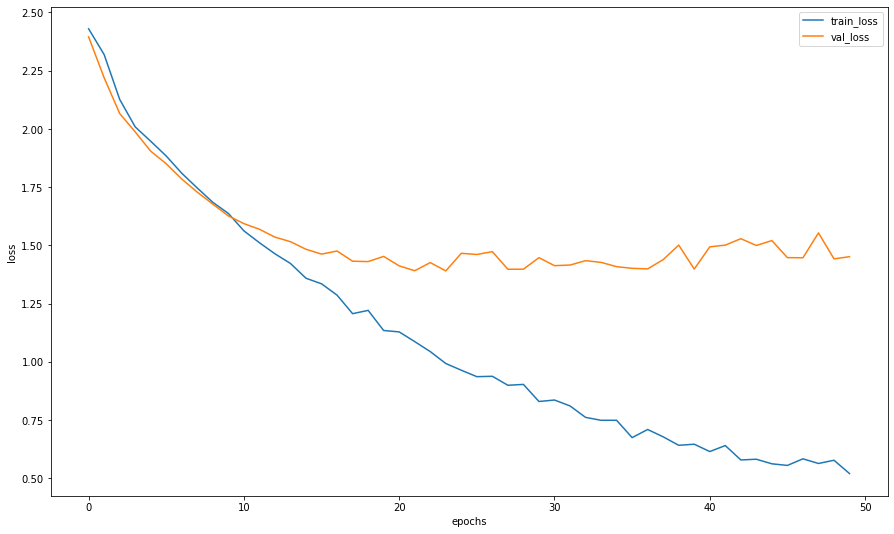

In [174]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [175]:
val_acc = list(x.cpu() for x in val_acc)

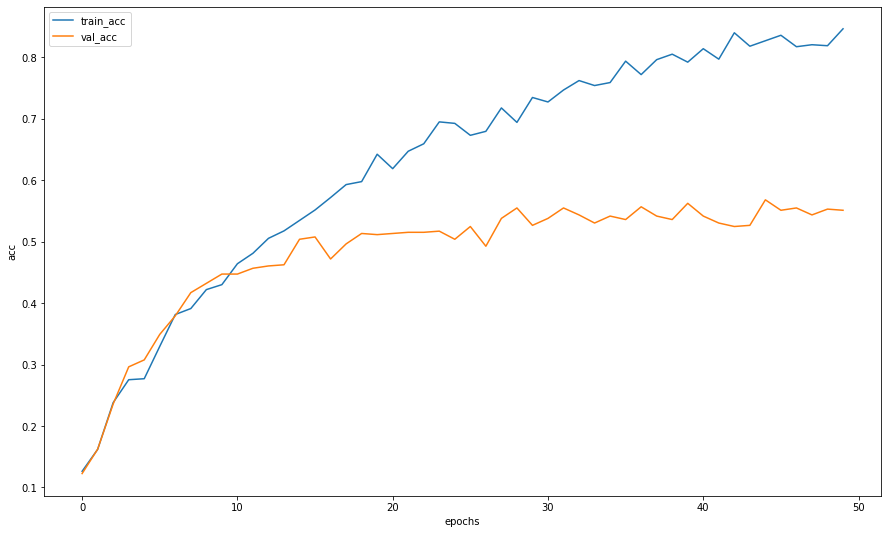

In [176]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [177]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [178]:
random_characters = int(np.random.uniform(0,500))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [179]:
idxs = list(map(int, np.random.uniform(0,500, 11)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_model, imgs)

In [180]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [181]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [182]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred.tolist(), average='weighted')


0.2606060606060606

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy


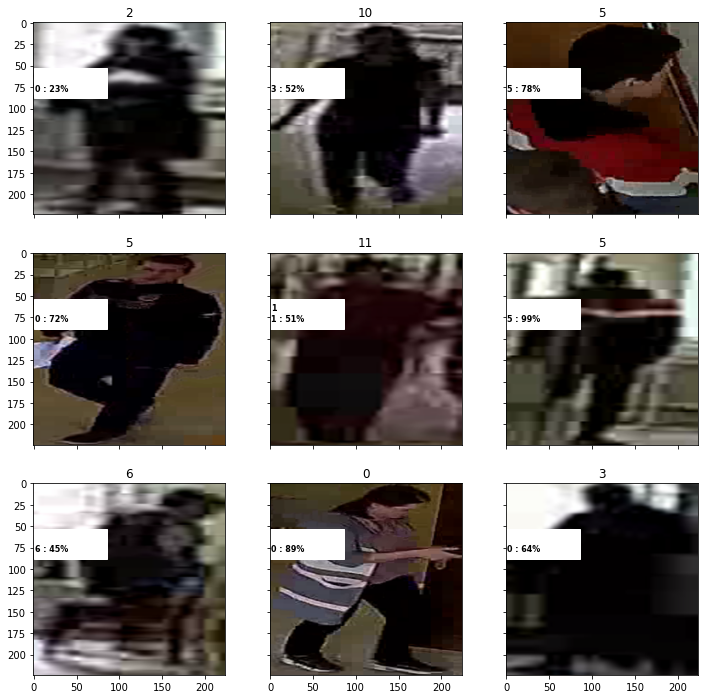

In [183]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [184]:
torch.save(my_model, 'cls_model.pt')